<a href="https://colab.research.google.com/github/GHjaz/SCC/blob/main/SCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def read_image(image_path):
    """
    Функция для чтения изображения из файла
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
    return img

In [ ]:
def read_mask(mask_path):
    """
    Функция для чтения маски из файла
    """
    mask = np.loadtxt(mask_path,delimiter=',')
    return mask

In [ ]:
def extract_ROI(image,mask):
    """
    Функция для выделения области интереса из изображения (цветовой мишени)
    """
    x,y,w,h = mask[0]
    obj = image[int(y*2):int(y*2)+int(h*2), int(x*2):int(x*2)+int(w*2)]
    return obj

In [ ]:
def calculate_average_color_polygon(img, polygon):
    '''
     Функция подсчета среднего значения цвета по каналам R,G,B в одном блоке цветовой мишени
    '''
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, [polygon], 0, 255, -1)
    average_color = cv2.mean(img, mask=mask)[:3]
    
    return average_color


In [ ]:
def mean_matrix(image, mask):
    arr = np.zeros((24, 3))
    for i in range(1, len(mask)-1, 2):
        x1, x2, x3, x4 = mask[i]
        y1, y2, y3, y4 = mask[i+1]
        polygon = np.array([[int(x1*2), int(y1*2)],
                            [int(x2*2), int(y2*2)],
                            [int(x3*2), int(y3*2)],
                            [int(x4*2), int(y4*2)]])
        # Вычисляем средние значения цвета внутри полигона
        means = calculate_average_color_polygon(image, polygon)
        arr[i//2] = means
    return arr

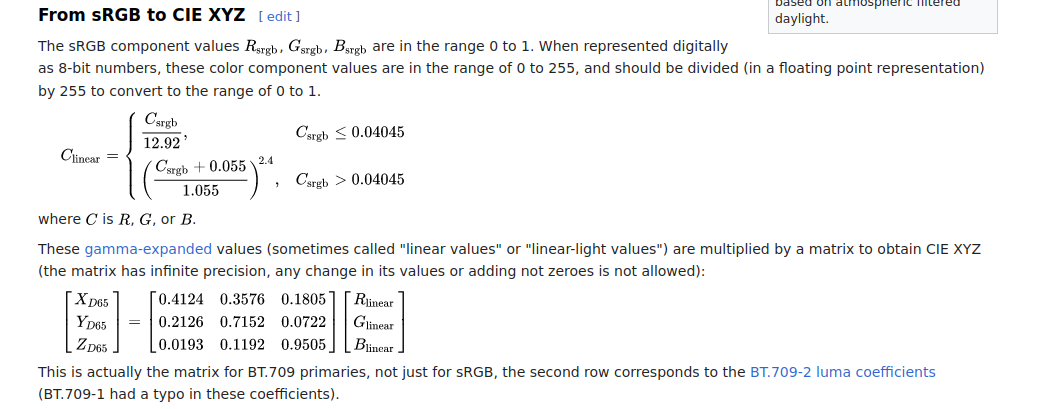

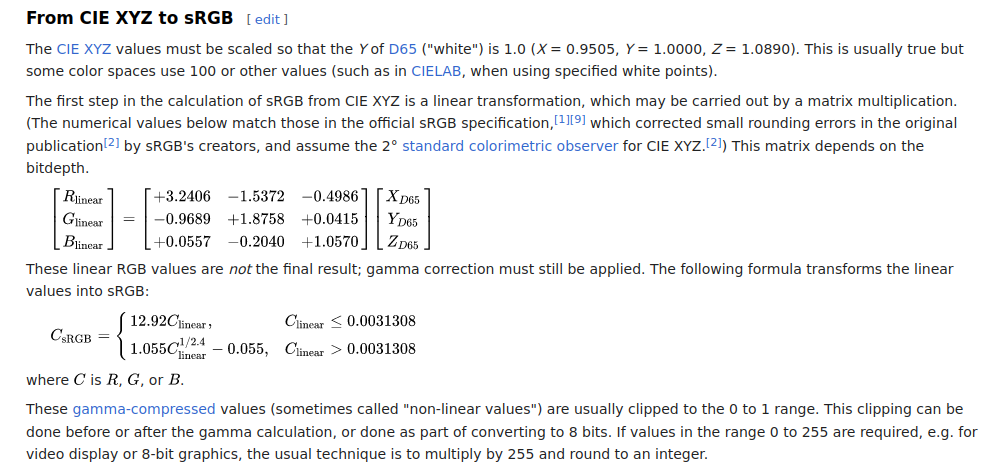

In [ ]:
def sRGB2lin (srgb):

    """Convert sRGB values to physically linear ones. The transformation is
       uniform in RGB, so *srgb* can be of any shape.

       *srgb* values should range between 0 and 1, inclusively.

    """
    gamma = ((srgb + 0.055) / 1.055)**2.4
    scale = srgb / 12.92
    return np.where (srgb > 0.04045, gamma, scale)

def gamma2sRGB(linear):
  '''
  
    Reversed convert

  '''
  return np.where (linear <= 0.0031308, 12.92 * linear, 1.055 * pow(linear, 1/2.4) - 0.055)


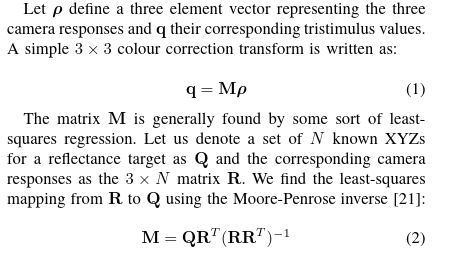

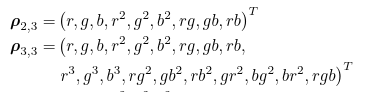

In [ ]:
def pcc(source, target, degree=2):

    r = target[:, 0]
    g = target[:, 1]
    b = target[:, 2]
    '''
      Значения полиномов для 2 и 3 порядка
    '''
    if degree == 2:
        N = np.column_stack((r, g, b, r*r, g*g, b*b, r*g, g*b, r*b))
    elif degree == 3:
        N = np.column_stack((r, g, b, r*r, r*g, r*b, g*g, g*b, b*b, r*r*r, r*r*g, r*r*b, r*g*g, r*g*b, r*b*b, g*g*g, g*g*b, g*b*b, b*b*b))
    
    '''
      МНК 
    
    '''
    y = np.atleast_2d(source)
    x = np.atleast_2d(N)

    return np.dot(np.transpose(x), np.linalg.pinv(np.transpose(y)))
    
def apply_pcc(image, matrix, degree):
  
    r, g, b = cv2.split(image)
    r = r.reshape(-1)
    g = g.reshape(-1)
    b = b.reshape(-1)
    if degree == 2:
        N = np.column_stack((r, g, b, r*r, g*g, b*b, r*g, g*b, r*b))
    elif degree == 3:    
        N = np.column_stack((r, g, b, r*r, r*g, r*b, g*g, g*b, b*b, 
                             r*r*r, r*r*g, r*r*b, r*g*g, r*g*b, r*b*b, g*g*g, g*g*b, g*b*b, b*b*b))
    else: 
        print('Error - unknown degree')
    x,y = N.shape

    batch1 = N[:int(x/2),:].dot(matrix)
    batch2 = N[int(x/2):,:].dot(matrix)
    
    corrected_image = np.concatenate((batch1,batch2))
    corrected_image = corrected_image.reshape(image.shape)

    return corrected_image


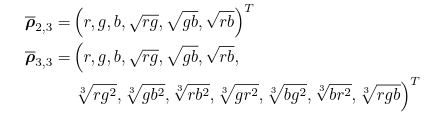

In [ ]:
def rpcc(source, target, degree=2):
    r = target[:, 0]
    g = target[:, 1]
    b = target[:, 2]

    ''' 
      Значения полиномов для 2 и 3 порядка
    '''

    if degree == 2:
        N = np.column_stack((r, g, b, np.sqrt(r*g), np.sqrt(g*b), np.sqrt(r*b)))
    elif degree == 3:
        N = np.column_stack((r, g, b, np.sqrt(r*g), np.sqrt(g*b), np.sqrt(r*b),
                             np.power(r*g*g, 1/3), np.power(g*b*b, 1/3), np.power(r*b*b, 1/3), 
                             np.power(g*r*r, 1/3), np.power(b*g*g, 1/3), np.power(b*r*r, 1/3)))
    
    y = np.atleast_2d(source)
    x = np.atleast_2d(N)

    return np.dot(np.transpose(x), np.linalg.pinv(np.transpose(y)))


def apply_rpcc(image, matrix, degree):
    r, g, b = cv2.split(image)
    r = r.reshape(-1)
    g = g.reshape(-1)
    b = b.reshape(-1)
    if degree == 2:
        N = np.column_stack((r, g, b, np.sqrt(r*g), np.sqrt(g*b), np.sqrt(r*b)))
    elif degree == 3:    
        N = np.column_stack((r, g, b, np.sqrt(r*g), np.sqrt(g*b), np.sqrt(r*b),
                             np.power(r*g*g, 1/3), np.power(g*b*b, 1/3), np.power(r*b*b, 1/3), 
                             np.power(g*r*r, 1/3), np.power(b*g*g, 1/3), np.power(b*r*r, 1/3)))
    else: 
        print('Error - unknown degree')
    
    x,y = N.shape
    
    batch1 = N[:int(x/2),:].dot(matrix)
    batch2 = N[int(x/2):,:].dot(matrix)
    '''
    batch1 = matrix.dot(N[:int(x/2),:])
    batch2 = matrix.dot(N[int(x/2):,:])
    '''
    corrected_image = np.concatenate((batch1,batch2))
    corrected_image = corrected_image.reshape(image.shape)
    return corrected_image

In [ ]:
canon600D = '/content/Canon600D_0003.jpg'
canon600D_m = '/content/Canon600D_0003_mask.txt'

canonDs = '/content/Canon1DsMkIII_0003.jpg'
canonDs_m = '/content/Canon1DsMkIII_0003_mask.txt'

img1, mask1 = read_image(canon600D), read_mask(canon600D_m)
img2, mask2 = read_image(canonDs), read_mask(canonDs_m)

img1_lin = sRGB2lin(img1/255)
img2_lin = sRGB2lin(img2/255)

'''
  Выделение цветовой мишени из изображения
'''
ROI1 = extract_ROI(img1_lin,
                        mask1)
ROI2 = extract_ROI(img2_lin,
                        mask2)
'''
  Подсчет средних значений R,G,B для каждого блока цветовой палитры для двух изображений
'''

R = mean_matrix(ROI1,mask1)
Q = mean_matrix(ROI2,mask2)

In [ ]:
MPCC2 = pcc(R,Q,2)    # Матрица цветового преобразования полинома 2 степени
MPCC3 = pcc(R,Q,3)    # Матрица цветового преобразования полинома 3 степени
MRPCC2 = rpcc(R,Q,2)  # Матрица цветового преобразования рут - полинома 2 степени
MRPCC3 = rpcc(R,Q,3)  # Матрица цветового преобразования рут - полинома 3 степени

In [ ]:
MPCC2.shape,MPCC3.shape

((9, 3), (19, 3))

In [ ]:
MRPCC2.shape, MRPCC3.shape

((6, 3), (12, 3))

In [ ]:
img_22p = apply_pcc(img2_lin, MPCC2, 2)
img_23p = apply_pcc(img2_lin, MPCC3, 3)


In [ ]:
img_22r = apply_rpcc(img2_lin, MRPCC2, 2)
img_23r = apply_rpcc(img2_lin, MRPCC3, 3)

In [ ]:
img_22p = gamma2sRGB(img_22p)
img_23p = gamma2sRGB(img_23p)
img_22r = gamma2sRGB(img_22r)
img_23r = gamma2sRGB(img_23r)
img_22p[0,0,:],img_23p[0,0,:],img_22r[0,0,:],img_23r[0,0,:]

<ipython-input-7-681f4a6fe96d>:19: RuntimeWarning: invalid value encountered in power
  return np.where (linear <= 0.0031308, 12.92 * linear, 1.055 * pow(linear, 1/2.4) - 0.055)


(array([0.03884917, 0.04881501, 0.0287593 ]),
 array([0.03884922, 0.04881523, 0.0287594 ]),
 array([0.06429869, 0.08131461, 0.05683392]),
 array([0.10093508, 0.12583527, 0.09501055]))

In [ ]:
plt.imsave('13.jpg',np.clip(img_22p,0.,1.))
plt.imsave('23.jpg',np.clip(img_23p,0.,1.))
plt.imsave('33.jpg',np.clip(img_22r,0.,1.))
plt.imsave('43.jpg',np.clip(img_23r,0.,1.))

In [ ]:
img_22p = read_image('13.jpg')
img_23p = read_image('23.jpg')
img_22r = read_image('33.jpg')
img_23r = read_image('43.jpg')

In [ ]:
def display_images(image1, image2, image3, image4, title1='Image source',title2='Image target', title3='Image PCC', title4='Image RPCC'):
    # Создание фигуры и осей с двумя подграфиками
    fig, axes = plt.subplots(2, 2)

    # Отображение изображения 1
    axes[0][0].imshow(image1)
    axes[0][0].set_title(title1)
    axes[0][0].axis('off')

    # Отображение изображения 2
    axes[1][0].imshow(image2)
    axes[1][0].set_title(title2)
    axes[1][0].axis('off')

    axes[0][1].imshow(image3)
    axes[0][1].set_title(title3)
    axes[0][1].axis('off')

    axes[1][1].imshow(image4)
    axes[1][1].set_title(title4)
    axes[1][1].axis('off')
    # Отображение фигуры
    plt.show()

In [ ]:
def correlation(image1, image2):
    # Преобразование изображений в формат float32

    # Расчет коэффициента корреляции
    correlation_coefficient = np.corrcoef(image1, image2)

    return correlation_coefficient

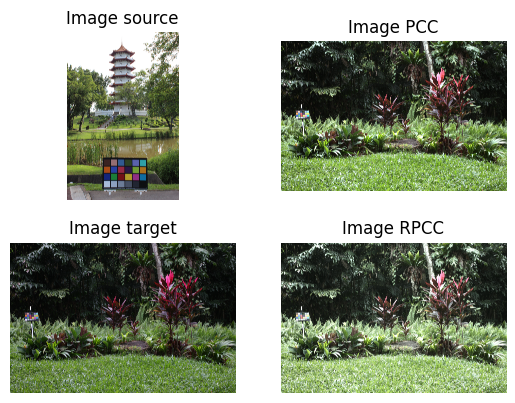

In [ ]:
display_images(img1,img2,img_22p,img_22r)

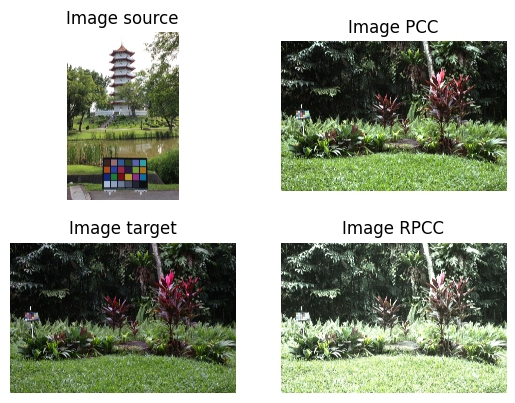

In [ ]:
display_images(img1,img2,img_23p,img_23r)

In [ ]:
ROI1 = extract_ROI(img1,
                        mask1)
ROI2 = extract_ROI(img2,
                        mask2)
'''
  Подсчет средних значений R,G,B для каждого блока цветовой палитры для двух изображений
'''

R = mean_matrix(ROI1,mask1)
Q = mean_matrix(ROI2,mask2)


In [ ]:
ROIPCC = extract_ROI(img_22p,
                        mask2)
ROIRPCC = extract_ROI(img_22r,
                        mask2)
'''
  Подсчет средних значений R,G,B для каждого блока цветовой палитры для двух изображений
'''

QPCC = mean_matrix(ROIPCC,mask2)
QRPCC = mean_matrix(ROIRPCC,mask2)

In [ ]:
ROIPCC1 = extract_ROI(img_23p,
                        mask2)
ROIRPCC1 = extract_ROI(img_23r,
                        mask2)
'''
  Подсчет средних значений R,G,B для каждого блока цветовой палитры для двух изображений
'''

QPCC3 = mean_matrix(ROIPCC1,mask2)
QRPCC3 = mean_matrix(ROIRPCC1,mask2)

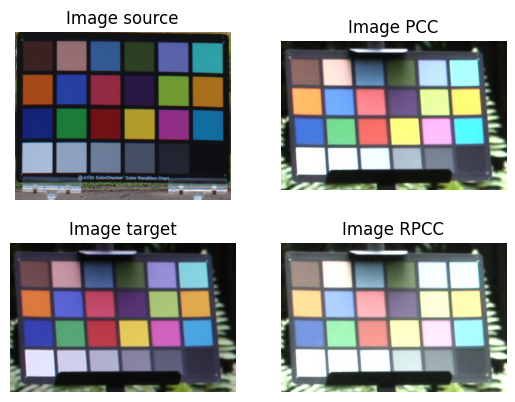

In [ ]:
display_images(ROI1,ROI2,ROIPCC,ROIRPCC)

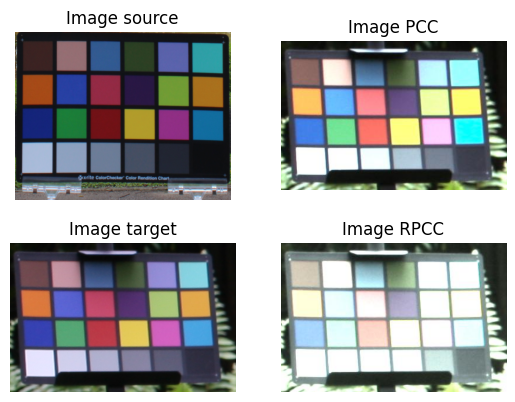

In [ ]:
display_images(ROI1,ROI2,ROIPCC1,ROIRPCC1)

In [ ]:
print('Source - Target correlation R,G,B-chanels:',correlation(R[:,0], Q[:,0])[0,1],correlation(R[:,1],Q[:,1])[0,1],correlation(R[:,2],Q[:,2])[0,1])
print('Source - PCC2 correlation R,G,B-chanels:',correlation(R[:,0], QPCC[:,0])[0,1],correlation(R[:,1],QPCC[:,1])[0,1],correlation(R[:,2],QPCC[:,2])[0,1])
print('Source - RPCC2 correlation R,G,B-chanels:',correlation(R[:,0], QRPCC[:,0])[0,1],correlation(R[:,1],QRPCC[:,1])[0,1],correlation(R[:,2],QRPCC[:,2])[0,1])
print('Source - PCC3 correlation R,G,B-chanels:',correlation(R[:,0], QPCC3[:,0])[0,1],correlation(R[:,1],QPCC3[:,1])[0,1],correlation(R[:,2],QPCC3[:,2])[0,1])
print('Source - RPCC3 correlation R,G,B-chanels:',correlation(R[:,0], QRPCC3[:,0])[0,1],correlation(R[:,1],QRPCC3[:,1])[0,1],correlation(R[:,2],QRPCC3[:,2])[0,1])


Source - Target correlation R,G,B-chanels: 0.9555281072815806 0.9560590573729841 0.9432963668706936
Source - PCC2 correlation R,G,B-chanels: 0.9409301713751295 0.8762836553411756 0.907596387295775
Source - RPCC2 correlation R,G,B-chanels: 0.8278211973709665 0.800539000403265 0.811242072667178
Source - PCC3 correlation R,G,B-chanels: 0.9383844379491876 0.8486789250649516 0.904801534987109
Source - RPCC3 correlation R,G,B-chanels: 0.6734496923085654 0.596849401067827 0.5332280571263636
